In [1]:
import mrsqm
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import timeit

In [2]:
# code to read arff data
# Source: https://github.com/alan-turing-institute/sktime/blob/main/sktime/utils/data_io.py

def load_from_arff_to_dataframe(

    full_file_path_and_name,
    has_class_labels=True,
    return_separate_X_and_y=True,
    replace_missing_vals_with="NaN",
):
    """Load data from a .ts file into a Pandas DataFrame.
    Parameters
    ----------
    full_file_path_and_name: str
        The full pathname of the .ts file to read.
    has_class_labels: bool
        true then line contains separated strings and class value contains
        list of separated strings, check for 'return_separate_X_and_y'
        false otherwise.
    return_separate_X_and_y: bool
        true then X and Y values should be returned as separate Data Frames (
        X) and a numpy array (y), false otherwise.
        This is only relevant for data.
    replace_missing_vals_with: str
       The value that missing values in the text file should be replaced
       with prior to parsing.
    Returns
    -------
    DataFrame, ndarray
        If return_separate_X_and_y then a tuple containing a DataFrame and a
        numpy array containing the relevant time-series and corresponding
        class values.
    DataFrame
        If not return_separate_X_and_y then a single DataFrame containing
        all time-series and (if relevant) a column "class_vals" the
        associated class values.
    """
    
    instance_list = []
    class_val_list = []

    data_started = False
    is_multi_variate = False
    is_first_case = True

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, "r", encoding="utf-8") as f:
        for line in f:

            if line.strip():
                if (
                    is_multi_variate is False
                    and "@attribute" in line.lower()
                    and "relational" in line.lower()
                ):
                    is_multi_variate = True

                if "@data" in line.lower():
                    data_started = True
                    continue

                # if the 'data tag has been found, the header information
                # has been cleared and now data can be loaded
                if data_started:
                    line = line.replace("?", replace_missing_vals_with)

                    if is_multi_variate:
                        if has_class_labels:
                            line, class_val = line.split("',")
                            class_val_list.append(class_val.strip())
                        dimensions = line.split("\\n")
                        dimensions[0] = dimensions[0].replace("'", "")

                        if is_first_case:
                            for _d in range(len(dimensions)):
                                instance_list.append([])
                            is_first_case = False

                        for dim in range(len(dimensions)):
                            instance_list[dim].append(
                                pd.Series(
                                    [float(i) for i in dimensions[dim].split(",")]
                                )
                            )

                    else:
                        if is_first_case:
                            instance_list.append([])
                            is_first_case = False

                        line_parts = line.split(",")
                        if has_class_labels:
                            instance_list[0].append(
                                pd.Series(
                                    [
                                        float(i)
                                        for i in line_parts[: len(line_parts) - 1]
                                    ]
                                )
                            )
                            class_val_list.append(line_parts[-1].strip())
                        else:
                            instance_list[0].append(
                                pd.Series(
                                    [float(i) for i in line_parts[: len(line_parts)]]
                                )
                            )

    x_data = pd.DataFrame(dtype=np.float32)
    for dim in range(len(instance_list)):
        x_data["dim_" + str(dim)] = instance_list[dim]

    if has_class_labels:
        if return_separate_X_and_y:
            return x_data, np.asarray(class_val_list)
        else:
            x_data["class_vals"] = pd.Series(class_val_list)

    return x_data

# code to visualize saliency map
# Source: https://github.com/mlgig/explanation4tsc/blob/master/3.%20Compare%20Metrics%20and%20Draw%20Figures.ipynb
def plot_time_series_with_color(ts, weight, save = False):   
    cas = weight
    
    def transform(X):
        ma,mi = np.max(X), np.min(X)
        X = (X - mi)/(ma-mi)
        return X*100
    cas = transform(cas)

    max_length1, max_length2 = len(weight),10000 #
    x1 = np.linspace(0,max_length1,num = max_length1)
    x2 = np.linspace(0,max_length1,num = max_length2)
    y1 = ts
    f = interp1d(x1, y1)

    fcas = interp1d(x1, cas)
    cas = fcas(x2)

    plt.figure(figsize = (5,3.5))
    plt.scatter(x2,f(x2), c = cas, cmap = 'jet', marker='.', s= 1,vmin=0,vmax = 100)    
    plt.colorbar()
    if save: plt.savefig('imgout/SM_%s_%s_Class%d_idx%d.png' %(dataset, explanation_method, label[i],i))


## Load dataset

Dataset is loaded under *sktime* format
https://www.sktime.org/en/stable/examples/loading_data.html#sktime_df_format

In [3]:
dataset="Coffee"
X_train,y_train = load_from_arff_to_dataframe("data/" + dataset + "/" + dataset + "_TRAIN.arff")
X_test,y_test = load_from_arff_to_dataframe("data/" + dataset + "/" + dataset + "_TEST.arff")

print(dataset)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Coffee
(28, 1) (28,)
(28, 1) (28,)


## Train with MrSQMClassifier

In [4]:
clf = mrsqm.MrSQMClassifier().fit(X_train,y_train)

## Test the model

In [6]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9642857142857143


## Explanation with saliency map
A saliency map is basically a weight vector for each point in the time series corresponding to a class. Higher weight means the data point is more relevant to the class according to the model.

*get_saliency_map* return a c X L array where c is the number of class and L is the length of the time series.

It is important to note that in MrSQM saliency map only works if there is at least 1 SAX representation used for training.

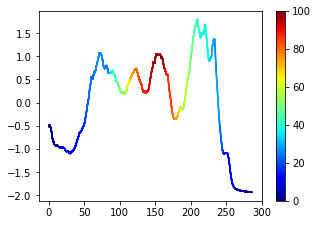

In [8]:
# This example visualise the saliency map of the 1st sample (class '0') in the Coffee dataset 
ts = X_train.iloc[0,0]
weight = clf.get_saliency_map(ts)
plot_time_series_with_color(ts, weight[0])

## Control the number of SAX and SFA representations
The parameters *nsax* and *nsfa* control the number of SAX and SFA representations produced from the raw data. The number of representations is *nsax* (or *nsfa*) x log(L) where L is the length of the time series.

Adding more representations (bigger *nsax* or *nsfa*) can improve the accuracy but slow down the training.

In [9]:
starttime = timeit.default_timer()
clf = mrsqm.MrSQMClassifier(nsax=1, nsfa=3).fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)

0.9642857142857143
Time to train and predict (sec): 1.3400286519899964


In [10]:
#parameters about training that the user can change
'''     
    Overview: MrSQM is an efficient time series classifier utilizing symbolic representations of time series. MrSQM implements four different feature selection strategies (R,S,RS,SR) that can quickly select subsequences from multiple symbolic representations of time series data.
    def __init__(self, strat = 'RS', features_per_rep = 500, selection_per_rep = 2000, nsax = 1, nsfa = 0, custom_config=None, random_state = None, sfa_norm = True):

    Parameters
    ----------
    
    strat               : str, feature selection strategy, either 'R','S','SR', or 'RS'. R and S are single-stage filters while RS and SR are two-stage filters. By default set to 'RS'.
    features_per_rep    : int, (maximum) number of features selected per representation. By deafault set to 500.
    selection_per_rep   : int, (maximum) number of candidate features selected per representation. Only applied in two stages strategies (RS and SR). By deafault set to 2000.
    nsax                : int, control the number of representations produced by sax transformation.
    nsfa                : int, control the number of representations produced by sfa transformation.
    custom_config       : dict, customized parameters for the symbolic transformation.
    random_state        : set random seed for classifier. By default 'none'.
    ts_norm             : time series normalisation (standardisation). By default set to 'True'.
    '''

starttime = timeit.default_timer()
clf = mrsqm.MrSQMClassifier(random_state=42,nsax=0, nsfa=1, sfa_norm = 'False').fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)


1.0
Time to train and predict (sec): 0.46172626689076424
